In [1]:
import logging
import time
from typing import Callable, List, Optional, Union, Dict
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torchvision.transforms import transforms
from torchvision import models
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
import torch.nn.functional as F
from torchmetrics import AUROC, Accuracy, F1, MetricCollection, Recall, StatScores
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, seed_everything, callbacks
import matplotlib.pyplot as plt
from PIL import Image

from solarnet.data import SDODatasetDataModule, SDOBenchmarkDataModule
from solarnet.data.sdo_dataset_ssl import SDODatasetSSLDataModule, SDODatasetSSL
from solarnet.data.dataset_config import datamodule_from_config
from solarnet.logging import InMemoryLogger
from solarnet.logging.tracking import NeptuneNewTracking, Tracking
from solarnet.models import CNNClassification, CNNRegression, model_from_config
from solarnet.utils.plots import plot_train_val_curve
from solarnet.utils.pytorch import get_training_summary, pytorch_model_summary
from solarnet.utils.target import compute_class_weight, flux_to_class_builder
from solarnet.utils.yaml import write_yaml
from solarnet.utils.callbacks import InfoLogCallback, PlotTrainValCurveCallback, TimerCallback

from pl_bolts.models.self_supervised import SimCLR
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.models.self_supervised.simclr.transforms import (
    SimCLREvalDataTransform, SimCLRTrainDataTransform)


# Self-Supervised Learning

## Goal
Train a model on unsupervised data to learn features from the images.

## Data
Sequential (temporal) images with 1 channel

## How ?
- Images from the sequence as different channels
- CNN for each image, then RNN to merge
- CNN for each image, then just flatten
    -

In [8]:
# dm = SDODatasetDataModule(
#     dataset_path=Path("../data/sdo-dataset-cls-171-12h-1"),
#     num_workers=20,
#     resize=64,
#     target_transform=flux_to_class_builder([{"Quiet": "< 1e-6"},{">=C": ">= 1e-6"}]),
#     batch_size=128,
# )
dm = SDOBenchmarkDataModule(
            Path("../data/sdo-benchmark"),
            batch_size=64,
            validation_size=0.1,
            channel=171,
            resize=64,
            seed=42,
            num_workers=20,
            target_transform=flux_to_class_builder([{"Quiet": "< 1e-6"},{">=C": ">= 1e-6"}]),
            time_steps=[3],
        )
dm.setup()

## Model

In [9]:
class Model(LightningModule):
    def __init__(
        self,
        channels: int,
        n_class: int,
        learning_rate: float = 1e-4,
        class_weight: torch.FloatTensor = None,
    ):
        super().__init__()
        self.save_hyperparameters()

        # Backbone
        backbone = resnet18(pretrained=False)
        backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        backbone.fc = nn.Identity()
        self.backbone = backbone

        # Classifier
        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(1536, 16),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(16, n_class),
        )

        self.loss_fn = nn.CrossEntropyLoss(weight=class_weight)

        # self.train_accuracy = Accuracy()
        # self.val_accuracy = Accuracy()

    def forward(self, image):
        # print(image.shape)

        # Split image channels in different tensors
        # img1, img2, img3 = torch.split(image, 1, 1)
        # print(img1.shape)

        # Siamese / multi-branch encoder
        img1 = self.backbone(image)
        # img2 = self.backbone(img2)
        # img3 = self.backbone(img3)
        # img4 = self.backbone(img4)
        # print(img1.shape)

        # img = torch.cat((img1, img2, img3), dim=1)
        # print(img.shape)

        img = self.classifier(img1)
        # print(img.shape)

        return img

    def training_step(self, batch, batch_id):
        return self.step(batch, step_type="train")

    def validation_step(self, batch, batch_id):
        return self.step(batch, step_type="val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, step_type="test")

    def step(self, batch, step_type: str):
        image, y = batch
        y_pred = self(image)
        # print(type(y), y)
        # print(type(y_pred), y_pred)
        loss = self.loss_fn(y_pred, y)

        self.log(f"{step_type}_loss", loss, prog_bar=True, sync_dist=True)

        # Compute accuracy
        # y_pred = F.softmax(y_pred, dim=1)
        # self.__getattr__(f"{step_type}_accuracy")(y_pred, y)
        # self.log(f"{step_type}_accuracy", self.__getattr__(f"{step_type}_accuracy"), on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.hparams.learning_rate,
        )
        return optimizer

In [10]:
model = Model.load_from_checkpoint("_test-SSL/0_SOLN-174/checkpoints/epoch=24-step=4299.ckpt", learning_rate=1e-4)
model.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Dropout2d(0.5),
            nn.Linear(512, 16),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(16, 2),
        )

finetuning_callback = callbacks.BackboneFinetuning(100, verbose=True, train_bn=False)

tracking = NeptuneNewTracking(parameters={"name": "finetune-SSL"}, tags=[], disabled=False)
tracking_logger = tracking.get_callback("pytorch-lightning")
trainer = pl.Trainer(
        gpus=2,
        logger=[InMemoryLogger(), tracking_logger],
        callbacks=[InfoLogCallback(), PlotTrainValCurveCallback(Path("."), "loss"), finetuning_callback],
        max_epochs=50,
        # val_check_interval=0.5,
        num_sanity_val_steps=0,
        # fast_dev_run=True,
        # log_every_n_steps=10,
        # flush_logs_every_n_steps=10,
        accelerator="dp",
    )

print("len", len(dm.dataset_train))

trainer.fit(model, datamodule=dm)

https://ui.neptune.ai/jdonzallaz/SolarNetNew/e/SOLN-184
NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
len 7432

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ResNet           | 11.2 M
1 | classifier | Sequential       | 8.2 K 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
17.8 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [11]:
model

Model(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [12]:
ds = SDODatasetSSL(
    Path("../data/sdo-dataset-ssl-171-7h") / "sdo-dataset-test.csv",
    transform=None,
)

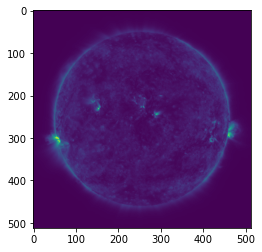

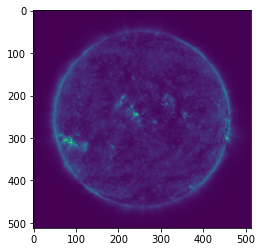

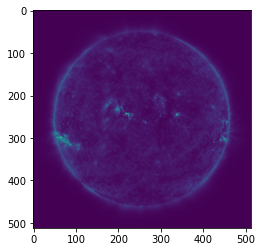

In [13]:
sample = 2
for i in range(3):
    plt.imshow(ds[sample][0][i]);
    plt.show();